# Optimization-based Control

In [10]:
import matplotlib.pyplot as plt
import pyomo.environ as pyo
import pyomo.dae as dae

plt.style.use("seaborn-v0_8")

In [11]:
# Create a model, set the time domain, and define the parameters
m = pyo.ConcreteModel()
m.t = dae.ContinuousSet(bounds=(0, 100))
m.u_in = pyo.Var(m.t, initialize=0, bounds=(-0.5, 0.5))
m.u_tout = pyo.Param(initialize=33)

m.temp_room = pyo.Var(m.t)
m.temp_wall = pyo.Var(m.t)
m.d_temp_room = dae.DerivativeVar(m.temp_room, wrt=m.t)
m.d_temp_wall = dae.DerivativeVar(m.temp_wall, wrt=m.t)

k_rw = 0.1
k_wo = 0.02
k_in = 0.5
T_target = 27

In [12]:
# Define the differential equations as constraints
def _temp_room_dot(m, t):
    return m.d_temp_room[t] == -k_rw * (m.temp_room[t] - m.temp_wall[t]) + k_in * m.u_in[t]

m.temp_room_dot = pyo.Constraint(m.t, rule=_temp_room_dot)

def _temp_wall_dot(m, t):
    return m.d_temp_wall[t] == k_rw * (m.temp_room[t] - m.temp_wall[t]) - k_wo * (m.temp_wall[t] - m.u_tout)

m.temp_wall_dot = pyo.Constraint(m.t, rule=_temp_wall_dot)

In [13]:
# Set initial conditions
m.temp_room[0].fix(30)
m.temp_wall[0].fix(30)

In [14]:
# Define the objective
def integral(m, t):
    # Don't increase the input too much, but keep the room temperature close to the target as soon as possible
    return m.u_in[t] ** 2 + (m.temp_room[t] - T_target) ** 2
    # return m.u_in[t] ** 2

m.integral = dae.Integral(m.t, wrt=m.t, rule=integral)


def terminal(m):
    return (m.temp_room[m.t.last()] - T_target) ** 2

m.terminal = pyo.Expression(rule=terminal)

m.obj = pyo.Objective(expr=m.integral + m.terminal, sense=pyo.minimize)

In [15]:
# Discretize model using Orthogonal Collocation
discretizer = pyo.TransformationFactory('dae.finite_difference')
discretizer.apply_to(m, nfe=300, wrt=m.t, scheme='BACKWARD')

# Solve the model
solver = pyo.SolverFactory('ipopt')
solution = solver.solve(m, tee=False)
print(solution)


Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 1202
  Number of variables: 1503
  Sense: unknown
Solver: 
- Status: ok
  Message: Ipopt 3.14.13\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 0.20047783851623535
Solution: 
- number of solutions: 0
  number of solutions displayed: 0


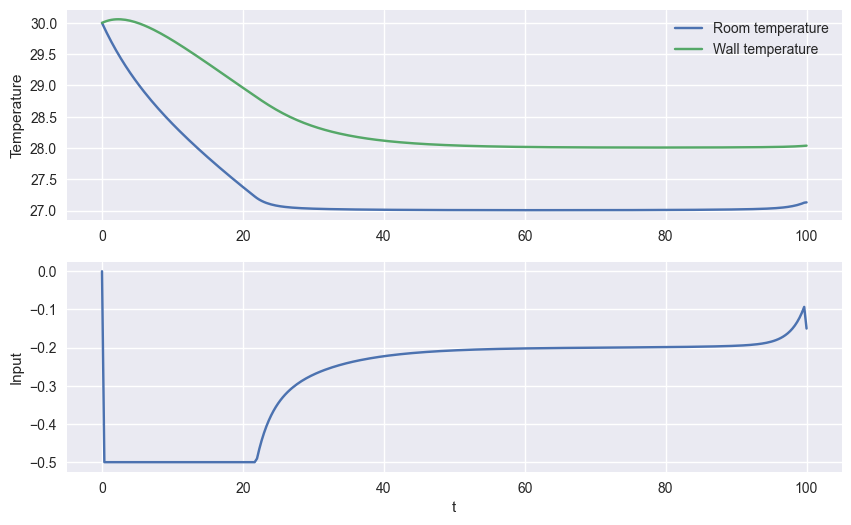

In [16]:
# Plot the results
fig, axs = plt.subplots(2, 1, figsize=(10, 6))
axs[0].plot(list(m.t), [pyo.value(m.temp_room[t]) for t in m.t], label='Room temperature')
axs[0].plot(list(m.t), [pyo.value(m.temp_wall[t]) for t in m.t], label='Wall temperature')
axs[0].set_ylabel('Temperature')
axs[0].legend(loc='best')

axs[1].plot(list(m.t), [pyo.value(m.u_in[t]) for t in m.t], label='Air conditioner input')
axs[1].set_xlabel('t')
axs[1].set_ylabel('Input')


plt.show()